In [1]:
import sys
import os
sys.path.append('/mnt/c/Users/frdnp/Desktop/Projects/dermoscopic-melanoma-classification/src/')

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms
from model import LiteSkinLesionClassifier

/mnt/c/Users/frdnp/Desktop/Projects/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        loss = output[0, class_idx]
        loss.backward()

        grads = self.gradients
        activations = self.activations
        pooled_grads = torch.mean(grads, dim=[0, 2, 3])

        for i in range(activations.shape[1]):
            activations[0, i, :, :] *= pooled_grads[i]

        cam = activations[0].sum(dim=0).cpu().numpy()
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
        cam -= cam.min()
        cam /= cam.max() + 1e-8
        return cam

In [4]:
def visualize_gradcam_on_image(img_tensor, cam, alpha=0.5):
    img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

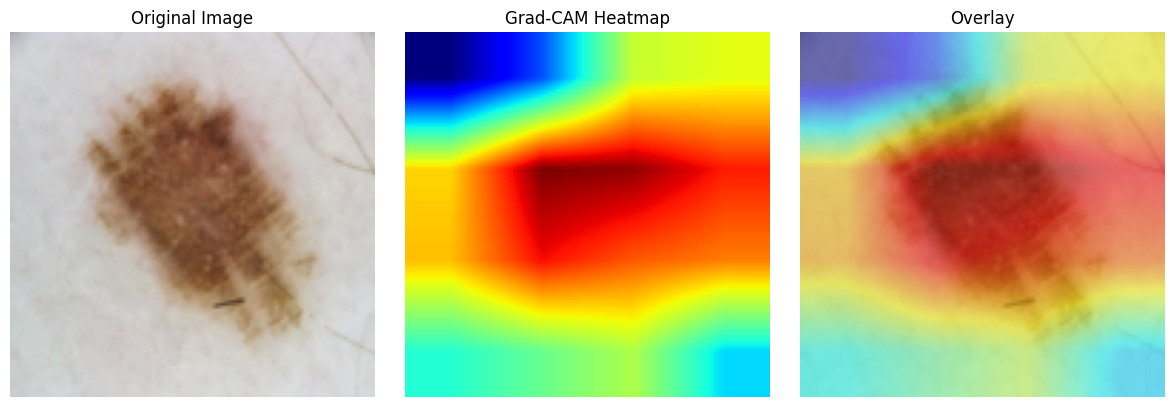

In [ ]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LiteSkinLesionClassifier(model_name='efficientnet_b0', pretrained=False).to(device)
    model.load_state_dict(torch.load("/mnt/c/Users/frdnp/Desktop/Projects/dermoscopic-melanoma-classification/experiments/checkpoints/best_model_efficientnet_b0_1.pt", map_location=device))

    target_layer = model.backbone.blocks[-1]
    cam_generator = GradCAM(model, target_layer)

    image_path = "/mnt/c/Users/frdnp/Desktop/Projects/dermoscopic-melanoma-classification/data/processed/artefact_removal/ISIC_0071118.jpg"  # Yüklenen görsel
    image = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)

    cam = cam_generator.generate_cam(input_tensor)
    transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()])
    visualize_gradcam_on_image(transform(image).unsqueeze(0).to(device), cam)
